In [1]:
import pandas as pd
import numpy as np

import math

from scipy.spatial import distance 
from shapleyx import rshdmr
import spotpy as sp

from scipy.stats import qmc

import matplotlib.pyplot as plt

from itertools import combinations

```
Results here 
```


# Notebook relevant version changes

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%;">
   
* V11 (CV 1-fold: 90.76 / LB: 97.66)
    * Create feature processing per dataset inside the  class FeatureProcessorClass
    * Renaming of the features per dataset
    * Remove latitude/longitude columns for model
    * Add mean_price_per_mwh_gas as feature


* V21 (CV 1-fold: 78.99 / LB: 86.43)
    * Add revealed_target lags from 2 to 7 days ago - inspired from [[Enefit] Baseline + cross-validation ☀️](https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation)
    * Use custom N_days_lags to specify the max number of revealed_target day lags

    
* V23 (CV 1-fold: 72.96 / LB: 83.79)
    * Map latitude & longitude for each county, using code from [mapping locations and county codes
](https://www.kaggle.com/code/fabiendaniel/mapping-locations-and-county-codes)
    * *historical_weather* and *forecast_weather* group by county too, and specify aggegate statistics 
    
    
    
    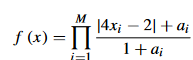
    
    
    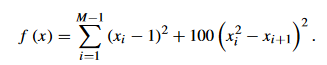

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
def get_column_labels(n):
    column_labels = []
    for column_index in range(1,n+1):
        column_labels.append('X' + str(column_index)) 
    return column_labels

def ishigami(m):
    n=3
    a=7
    b=0.1
    sampler = qmc.Sobol(d=n, scramble=True, seed=123)
    S = sampler.random_base2(m=m)
    S=S*2*np.pi - np.pi
    Y = np.sin(S[  : ,0]) + a*(np.sin(S[  : ,1])**2) + b*S[  : ,2]**4 * np.sin(S[  : ,0])
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

    
    

In [19]:
# m = 6 -> 64 samples
# m = 7 -> 128 samples
# m = 8 -> 256 samples
# m = 9 -> 512 samples
# m = 10 -> 1024 samples
# m = 11 -> 2048 samples 
# m = 12 -> 4096 samples
# m = 13 -> 8192 samples

m=11
dataframe = ishigami(m)
print(len(dataframe), 'samples generated')

2048 samples generated


In [20]:
dataframe


,X1,X2,X3,Y
0,0.607133,0.982525,-0.234066,5.415103
1,-1.743749,-2.409093,1.878209,0.919442
2,-0.632661,2.509733,-2.727369,-1.420984
3,1.728958,-1.090534,1.032413,6.605523
4,2.709205,1.710561,3.031147,10.820581
...,...,...,...,...
2043,2.707818,-1.095450,-2.460897,7.495677
2044,1.724210,1.705651,-1.321178,8.162827
2045,-0.637320,-0.375950,2.769930,-3.154284
2046,-1.748203,0.275347,-2.043500,-2.183310


 found a dataframe

Transforming data to unit hypercube

['X1', 'X2', 'X3']
X1 : min -3.1390334129985784 max 3.1400196245925356
X2 : min -3.1393275590109404 max 3.1396297101110324
X3 : min -3.1404242150682102 max 3.1408652322040584

Building basis functions

 number of terms of order  1 is  30
 number of terms of order  2 is  75

Running regression analysis

running ARD
0 0.46453926906163073 inf
1 0.6042014487669262 30.06466600496725
2 0.7361737011081753 21.84242566954818
3 0.8554977185942519 16.20867701555436
4 0.9419996021102405 10.111293301649926
5 0.9672809679484636 2.6837979317176535
6 0.9790328591482306 1.2149408071877907
7 0.9872096267362125 0.83518826886932
8 0.994993353372075 0.7884573271024551
9 0.997693987393346 0.27142231775905956
10 0.9996474213534027 0.19579490151688145
11 0.9998310636940113 0.01837071118134898
finished
Iteration: 11, number of features in the model: 13
Iteration: 11, number of features in the model: 13
(11, 0.9998310636940113)
Fit Execution Time : 0.8836

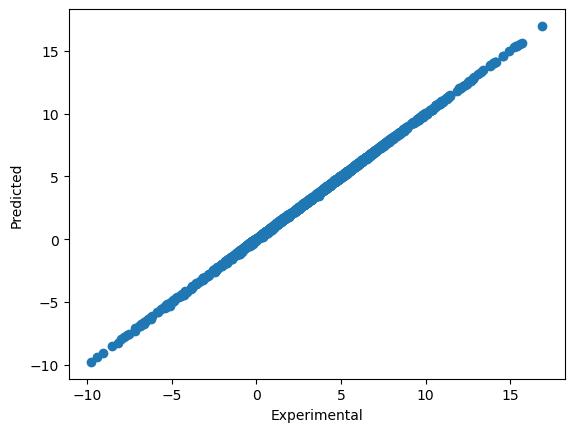


Running bootstrap resampling 1000 samples for 95.0% CI

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Completed bootstrap resampling


                  Completed all analysis 
                 ------------------------ 

 I have been impressed with the urgency of doing. Knowing
is not enough; we must apply. Being willing is not enough;
we must do.  Leonardo da Vinci



In [21]:

model = rshdmr(dataframe,
               polys = [10, 5],
               n_iter = 250,
               method = 'ard_cv'
              )
               
sob, shap, total = model.run_all() 

In [9]:
sob

,index,lower,upper
derived_labels,,,
X1,0.313042,0.311511,0.314629
X1_X3,0.240415,0.238848,0.241959
X2,0.446360,0.444613,0.448160


In [8]:
shap

,label,effect,scaled effect,lower,upper
0,X1,0.433250,0.433329,0.431797,0.434849
1,X2,0.446360,0.446441,0.444697,0.448250
2,X3,0.120208,0.120230,0.119446,0.121000


In [10]:
total

,label,total
0,X1,0.553458
1,X2,0.446360
2,X3,0.240415


In [22]:
model.get_pawnx(1000, 1000, 1000, alpha=0.05)

for the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.061
3
1 0.198 0.027909946452832905
2 0.3715 0.11937881252131805
3 0.09 0.0021564320068112527


,minimum,mean,median,maximum,stdev,null hyp
X1,0.149,0.197417,0.198,0.266,0.02791,reject
X2,0.173,0.373989,0.3715,0.545,0.119379,reject
X3,0.084,0.090401,0.09,0.099,0.002156,reject


In [23]:
model.get_pawn()

,minimum,mean,median,maximum,CV,stdev
X1,0.167485,0.232291,0.249491,0.327606,0.239373,0.055604
X2,0.213886,0.348006,0.393564,0.503575,0.315472,0.109786
X3,0.047235,0.097585,0.087646,0.193590,0.502061,0.048994


In [11]:


def xsampler(n, ranges):
    num_features = len(ranges)
    lower = []
    upper = []
    sampler = qmc.LatinHypercube(d=num_features)
    sample = sampler.random(n=n)
    
    for the_range in ranges:
        lower.append(ranges[the_range][0])
        upper.append(ranges[the_range][1])

    sample_scaled = qmc.scale(sample, lower, upper)

    return sample_scaled 

In [21]:

def calc_function(S) : 
    Y = np.sin(S[  : ,0]) + a*(np.sin(S[  : ,1])**2) + b*S[  : ,2]**4 * np.sin(S[  : ,0])
    return Y

In [18]:
Y

array([2.81543533, 2.27871505, 2.37564839, 0.28127805, 3.40396323,
       5.87660685, 0.13106313, 4.83846859, 0.98543148, 6.82142288])

In [22]:
x_ref = xsampler(10, model.ranges)
y_ref = calc_function(x_ref)

In [23]:
y_ref

array([ 7.65223156,  0.86648601,  6.53193799,  6.5104644 ,  1.90764346,
        5.98160418,  2.07216222,  1.51088091, -3.34965876,  4.6644092 ])

In [25]:
def get_pawnx(Nu, Nc, M, alpha=0.05):
    calpha = np.sqrt(-np.log(alpha/2)/2)
    Dnm = np.sqrt((Nu+Nc)/(Nu*Nc))
    critical_value = Dnm*calpha
    print(f'for the Kolmogorov–Smirnov test with alpha = {alpha:.3f} the critical value is {critical_value:.3f}')
    
    results = {} 
    resultsp = {}
    labels = model.X.columns
    num_features = len(model.ranges)
    #generate reference set
    x_ref = xsampler(Nu, model.ranges)
    y_ref = calc_function(x_ref)
    print(num_features)
    for j in range(num_features):
        accept = 'accept'
        all_stats = []
        all_p = []
        for i in range(M):
            Xi = np.random.rand()
            Xn = xsampler(Nc, model.ranges)
            Xn[:,j] = Xi
            Yn = calc_function(Xn)
            ks = ks_2samp(y_ref, Yn)
            all_stats.append(ks.statistic)
            all_p.append(ks.pvalue)

        min = np.min(all_stats)
        mean = np.mean(all_stats)
        median = np.median(all_stats)
        max = np.max(all_stats)
        std = np.std(all_stats)

        minp = np.min(all_p)
        meanp = np.mean(all_p)
        medianp = np.median(all_p)
        maxp = np.max(all_p)
        stdp = np.std(all_p)
        if minp < alpha :
            accept = 'reject'

        results[labels[j]] = [min, mean, median, max, std, accept] 
        resultsp[labels[j]] = [minp, meanp, medianp, maxp, stdp, accept] 
        print(j+1, np.median(all_stats),np.std(all_stats))

    headings = ['minimum', 'mean', 'median', 'maximum', 'stdev', 'null hyp']
    results = pd.DataFrame(results).T
    resultsp = pd.DataFrame(resultsp).T

    results.columns = headings
    resultsp.columns = headings
    return results  

In [31]:
get_pawnx(10000, 10000, 2000, alpha=0.05)

for the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.019
3
1 0.1931 0.026289491022840287
2 0.37229999999999996 0.11389708652880459
3 0.0834 0.001510445092514124


,minimum,mean,median,maximum,stdev,null hyp
X1,0.1557,0.196172,0.1931,0.2568,0.026289,reject
X2,0.1848,0.37275,0.3723,0.5328,0.113897,reject
X3,0.0784,0.082835,0.0834,0.0864,0.00151,reject


In [32]:
get_pawnx(10000, 10000, 2000, alpha=0.05)

for the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.019
3
1 0.1973 0.024711395342027934
2 0.373 0.11147416655861347
3 0.0839 0.0015305464089664183


,minimum,mean,median,maximum,stdev,null hyp
X1,0.1572,0.197935,0.1973,0.2536,0.024711,reject
X2,0.1864,0.372458,0.373,0.5291,0.111474,reject
X3,0.0794,0.083286,0.0839,0.0876,0.001531,reject


In [33]:
model.get_pawnx(1000,1000,100)

for the Kolmogorov–Smirnov test with alpha = 0.050 the critical value is 0.061
3
1 0.1965 0.025449880156888757
2 0.3805 0.10951527929928317
3 0.091 0.0037791004220581394


,minimum,mean,median,maximum,stdev,null hyp
X1,0.151,0.19494,0.1965,0.235,0.02545,reject
X2,0.195,0.37994,0.3805,0.538,0.109515,reject
X3,0.082,0.09072,0.091,0.102,0.003779,reject


In [18]:
model.get_pawn()

,minimum,mean,median,maximum,CV,stdev
X1,0.173678,0.267370,0.283996,0.360625,0.264597,0.070745
X2,0.192656,0.377558,0.416767,0.606671,0.308789,0.116586
X3,0.129808,0.198563,0.192969,0.260216,0.212425,0.042180


In [ ]:
from scipy.stats import ks_2samp
import numpy as np
import pandas as pd

def estimate_pawn(
    var_names,
    D,
    X: np.ndarray,
    Y: np.ndarray,
    S: int = 10,
    print_to_console: bool = False,
    seed: int = None,
):
    """Performs PAWN sensitivity analysis.

    The PAWN method [1] is a moment-independent approach to Global Sensitivity
    Analysis (GSA). It is described as producing robust results at relatively
    low sample sizes (see [2]) for the purpose of factor ranking and screening.

    The distribution of model outputs is examined rather than
    their variation as is typical in other common GSA approaches. The PAWN
    method further distinguishes itself from other moment-independent
    approaches by characterizing outputs by their cumulative distribution
    function (CDF) as opposed to their probability distribution function.
    As the CDF for a given random variable is typically normally distributed,
    PAWN can be more appropriately applied when outputs are highly-skewed or
    multi-modal, for which variance-based methods may produce unreliable
    results.

    PAWN characterizes the relationship between inputs and outputs by
    quantifying the variation in the output distributions after conditioning
    an input. A factor is deemed non-influential if distributions coincide at
    all ``S`` conditioning intervals. The Kolmogorov-Smirnov statistic is used
    as a measure of distance between the distributions.

    This implementation reports the PAWN index at the min, mean, median, and
    max across the slides/conditioning intervals as well as the coefficient of
    variation (``CV``) and standard deviation (``stdev``). The median value is the
    typically reported value. As the ``CV`` is (standard deviation / mean), it
    indicates the level of variability across the slides, with values closer to zero
    indicating lower variation.


    Notes
    -----
    Compatible with:
        all samplers

    This implementation ignores all NaNs.

    When applied to grouped factors, the analysis is conducted on each factor
    individually, and the mean of their results are reported.


    Examples
    --------
        >>> X = latin.sample(problem, 1000)
        >>> Y = Ishigami.evaluate(X)
        >>> Si = pawn.analyze(problem, X, Y, S=10, print_to_console=False)


    Parameters
    ----------
    problem : dict
        The problem definition
    X : numpy.array
        A NumPy array containing the model inputs
    Y : numpy.array
        A NumPy array containing the model outputs
    S : int
        Number of slides; the conditioning intervals (default 10)
    print_to_console : bool
        Print results directly to console (default False)
    seed : int
        Seed value to ensure deterministic results


    References
    ----------
    1. Pianosi, F., Wagener, T., 2015.
           A simple and efficient method for global sensitivity analysis
           based on cumulative distribution functions.
           Environmental Modelling & Software 67, 1-11.
           https://doi.org/10.1016/j.envsoft.2015.01.004

    2. Pianosi, F., Wagener, T., 2018.
           Distribution-based sensitivity analysis from a generic input-output sample.
           Environmental Modelling & Software 108, 197-207.
           https://doi.org/10.1016/j.envsoft.2018.07.019

    3. Baroni, G., Francke, T., 2020.
           An effective strategy for combining variance- and
           distribution-based global sensitivity analysis.
           Environmental Modelling & Software, 134, 104851.
           https://doi.org/10.1016/j.envsoft.2020.104851

    4. Baroni, G., Francke, T., 2020.
           GSA-cvd
           Combining variance- and distribution-based global sensitivity analysis
           https://github.com/baronig/GSA-cvd
    """
    if seed:
        np.random.seed(seed)


    results = np.full((D, 6), np.nan)
    temp_pawn = np.full((S, D), np.nan)

    step = 1 / S
    for d_i in range(D):
        seq = np.arange(0, 1 + step, step)
        X_di = X[:, d_i]
        X_q = np.nanquantile(X_di, seq)

        for s in range(S):
            Y_sel = Y[(X_di >= X_q[s]) & (X_di < X_q[s + 1])]
            if len(Y_sel) == 0:
                # no available samples
                continue

            # KD value
            # Function returns a KS object which holds the KS statistic
            # and p-value
            # Note from scipy documentation:
            # if the K-S statistic is small or the p-value is high, then
            # we cannot reject the hypothesis that the distributions of
            # the two samples are the same.
            ks = ks_2samp(Y_sel, Y)
            temp_pawn[s, d_i] = ks.statistic

        p_ind = temp_pawn[:, d_i]
        mins = np.nanmin(p_ind)
        mean = np.nanmean(p_ind)
        med = np.nanmedian(p_ind)
        maxs = np.nanmax(p_ind)
        stdev = np.nanstd(p_ind)
        cv = np.nanstd(p_ind) / mean
        results[d_i, :] = [mins, mean, med, maxs, cv, stdev]

    resultsDF = pd.DataFrame(results, columns=["minimum","mean","median","maximum","CV", "stdev"]    )
    resultsDF.set_index(var_names, inplace=True)
    
    return resultsDF

In [17]:
model.get_pawn()

,minimum,mean,median,maximum,CV,stdev
X1,0.173678,0.267370,0.283996,0.360625,0.264597,0.070745
X2,0.192656,0.377558,0.416767,0.606671,0.308789,0.116586
X3,0.129808,0.198563,0.192969,0.260216,0.212425,0.042180
